# DO AMAILYS

In [41]:
import torch
from tp1 import MSE, Linear
import matplotlib.pyplot as plt 
from torch import nn
from tqdm import tqdm

## Question 1

In [42]:
x = torch.randn(20, 10)
y = torch.randn(20, 1)

# Les paramètres du modèle à optimiser

w = torch.nn.Parameter(torch.randn(10,1))
b = torch.nn.Parameter(torch.randn(1))

epsilon = 0.05

u=[]

optim = torch.optim.SGD(params=[w,b],lr=epsilon)

for n_iter in range(100):

    y_hat=Linear.apply(x,w,b)
    loss=MSE.apply(y_hat,y)

    loss.backward()

    optim.step() # Mise-à-jour des paramètres w et b
    optim.zero_grad()

    u.append(loss.item())


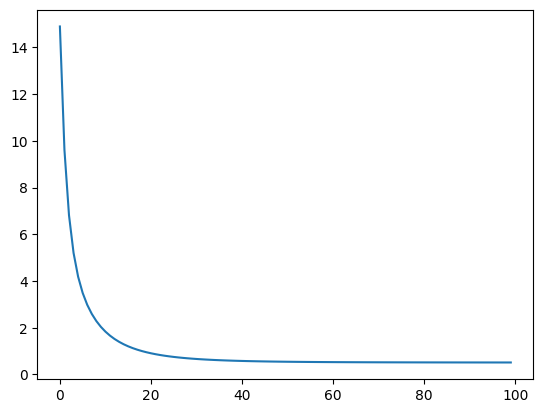

In [43]:
plt.plot(range(100),u)

## Question 2

### Sans sequential 

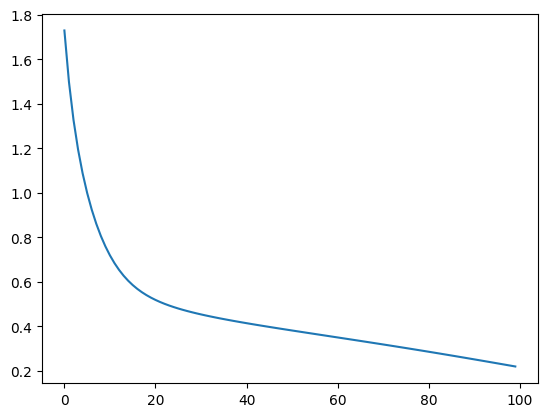

In [44]:
import numpy as np
from torch import nn

mse=torch.nn.MSELoss()
tanh=torch.nn.Tanh()
linear=torch.nn.Linear(10,20)
linear2=nn.Linear(20,1)
optim = torch.optim.SGD(params=list(linear.parameters())+list(linear2.parameters()),lr=epsilon)
u=[]
for n_iter in range(100):

    loss=mse(linear2(tanh(linear(x))),y)
    loss.backward()

    optim.step() # Mise-à-jour des paramètres w et b
    optim.zero_grad()

    u.append(loss.item())

plt.plot(range(100),u);

### Avec sequential 

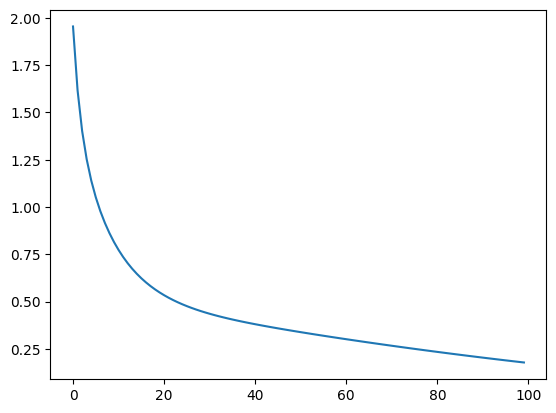

In [45]:
seq=nn.Sequential(
    nn.Linear(10,20),
    nn.Tanh(),
    nn.Linear(20,1)
)

optim = torch.optim.SGD(params=seq.parameters(),lr=epsilon)
u=[]
for n_iter in range(100):

    loss=mse(seq(x),y)
    loss.backward()

    optim.step() # Mise-à-jour des paramètres w et b
    optim.zero_grad()

    u.append(loss.item())

plt.plot(range(100),u);

### Réseau de neurones

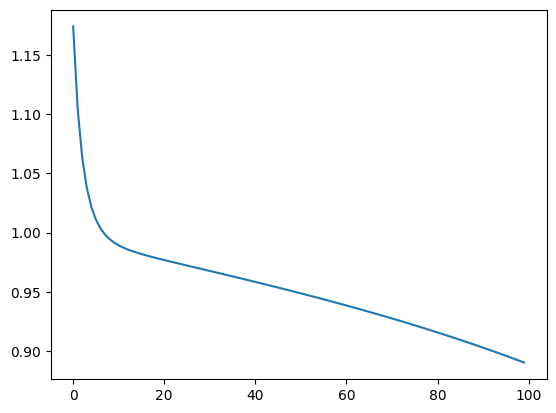

In [46]:
class MonModuleLineaire(torch.nn.Module):
    
    def __init__(self):
        super(MonModuleLineaire,self).__init__()
# deux sous-modules linéaires
        self.un = torch.nn.Linear(10,100)
        self.deux=torch.nn.Tanh()
        self.trois = torch.nn.Linear(100,1)
    
    
    def forward(self,x):
# définir le comportement forward du module

        return self.trois(self.deux(self.un(x)))
    
    
m = MonModuleLineaire()
x = torch.randn(100,10)
y = torch.randn(100, 1)
optim = torch.optim.SGD(params=list(m.parameters()),lr=epsilon)
mse=nn.MSELoss()
u=[]
for n_iter in range(100):

    yhat=m(x)
    loss=mse(yhat,y)

    loss.backward()

    optim.step() # Mise-à-jour des paramètres w et b
    optim.zero_grad()

    u.append(loss.item())


plt.plot(range(100),u);

In [47]:
print(m)

MonModuleLineaire(
  (un): Linear(in_features=10, out_features=100, bias=True)
  (deux): Tanh()
  (trois): Linear(in_features=100, out_features=1, bias=True)
)


## Question 3 - Dataset 

In [48]:
from sklearn.datasets import fetch_openml

# Fixer DATA_PATH au répertoire où les données seront téléchargées.
x, y = fetch_openml('mnist_784', return_X_y=True, as_frame=False, data_home=fr"\\wsl.localhost\Ubuntu\home\amailys\TP\AMAL\TP2")


In [49]:
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
class MonDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(scaler.fit_transform(x),dtype=torch.float32).to(device)
        y=y.astype(np.int64)
        self.y = torch.tensor(y,dtype=torch.long).to(device)
        
    def __getitem__(self,index ):

        image =self.x[index]
        label = self.y[index]
        
        return image, label
    
    def __len__(self):

        return len(self.x)

In [50]:
from torch.utils.data import DataLoader
ds=MonDataset(x,y)
data = DataLoader(ds, shuffle=True, batch_size=50)


for images, labels in data:
    print(images.shape)  # Devrait être [50, 784] pour un batch de 50 images aplaties
    print(labels.shape)  # Devrait être [50] pour les labels associés 
    break

torch.Size([50, 784])
torch.Size([50])


## GPU

In [51]:
import torch

if torch.cuda.is_available():
    print("CUDA is available!")
else:
    print("CUDA is not available.")


CUDA is not available.


## Checkpointing

In [52]:
from pathlib import Path
savepath = Path("model.pch")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [53]:
import os 

class State:
    def __init__(self, model, optim,save_dir="checkpoint_dir",save_name="checkpoint.pt"):
        self.model = model #le modèle PyTorch que tu veux sauvegarder 
        self.optim = optim #l'optimiseur utilisé pour entraîner ce modèle.
        self.epoch = 0
        self.save_dir = save_dir #  le répertoire où les checkpoints seront sauvegardés et chargés.
        self.save_name = save_name

        if not os.path.exists(self.save_dir):
            os.makedirs(self.save_dir)
    
    def save(self,epoch):
        checkpoint = {
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optim.state_dict(),
            'epoch': epoch,
        }
        checkpoint_path = os.path.join(self.save_dir, self.save_name)
        torch.save(checkpoint, checkpoint_path)

    def load(self,checkpoint_path=None):
        if checkpoint_path is None:
            checkpoint_path = os.path.join(self.save_dir,self.save_name)

        if not os.path.isfile(checkpoint_path):
            raise FileNotFoundError(f"No checkpoint found at {checkpoint_path}")

        checkpoint = torch.load(checkpoint_path,map_location=torch.device('cpu'))
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optim.load_state_dict(checkpoint['optimizer_state_dict'])
        
        epoch = checkpoint['epoch']
        
        print(f"Checkpoint loaded from {checkpoint_path} (Epoch: {epoch})")
        
        return epoch



## Auto encodeur

In [54]:
import torch.nn as nn

class AE(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        self.encoder = nn.Linear(28 * 28, 128)
        self.relu=nn.ReLU()
         
        self.decoder = nn.Linear(128, 28 * 28)
        self.sigmoid=nn.Sigmoid()

        self.decoder.weight = nn.Parameter(self.encoder.weight.t())

 
    def forward(self, x):
        encoded = self.relu(self.encoder(x))
        decoded = self.sigmoid(self.decoder(encoded))
        return decoded

### Séparation en test / train 

In [55]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test=train_test_split(x,y,train_size=0.8)
ds_train=MonDataset(X_train,y_train)
dl_train = DataLoader(ds_train, shuffle=True, batch_size=50)

ds_test=MonDataset(X_test,y_test)
dl_test = DataLoader(ds_test, shuffle=True, batch_size=50)

### Entraînement du modèle 

In [56]:
from datetime import datetime
import torchvision.utils as vutils

In [57]:
from torch.utils.tensorboard import SummaryWriter

current_time = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

#log_dir = os.path.join(os.path.expanduser("~"), "runs", f"test_{current_time}")


venv_dir = "/home/amailys/TP/AMAL/TP2" # Dossier où se trouve le script
log_dir = os.path.join(venv_dir, "logs", f"test_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
writer = SummaryWriter(log_dir=log_dir)

model = AE().to(device)

epsilon=0.001

optimizer=torch.optim.Adam(model.parameters(),lr=epsilon)
loss_fn=nn.MSELoss()

checkpoint_dir=os.getcwd()
save_name="checkpoints.pt"
state=State(model, 
            optimizer,
            save_dir=checkpoint_dir,
            save_name=save_name
            )


checkpoint_path = os.path.join(checkpoint_dir, save_name)
if os.path.exists(checkpoint_path):
    start_epoch= state.load(checkpoint_path)
else:
    start_epoch = 0 


u=[]
v=[]
num_epochs = 10  # Nombre d'époques

for epoch in tqdm(range(start_epoch,start_epoch+num_epochs)):
    
    
    cumloss_train=0
    for data in dl_train:
        # Obtenir les entrées
        inputs, _ = data  # _ car nous n'avons pas besoin des labels

        outputs = model(inputs)
        loss = loss_fn(outputs, inputs)

        cumloss_train+=loss.item()

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()



    cumloss_test=0
    with torch.no_grad(): 
        for data in dl_test:
            inputs, _ = data  # _ car nous n'avons pas besoin des labels
            outputs = model(inputs)
            loss = loss_fn(outputs, inputs)

            cumloss_test+=loss.item()

    # plot train loss
    val_train=cumloss_train/(70_000*0.8//50)
    u.append(val_train)
    writer.add_scalar("Train loss", val_train, epoch)

    #plot test loss
    val_test=cumloss_test/(70_000*0.2//50)
    v.append(val_test)
    writer.add_scalar("Test loss", val_test, epoch)

    if (epoch + 1) % 10 == 0:
        state.save(epoch + 1)

writer.close()

100%|██████████| 10/10 [00:40<00:00,  4.08s/it]


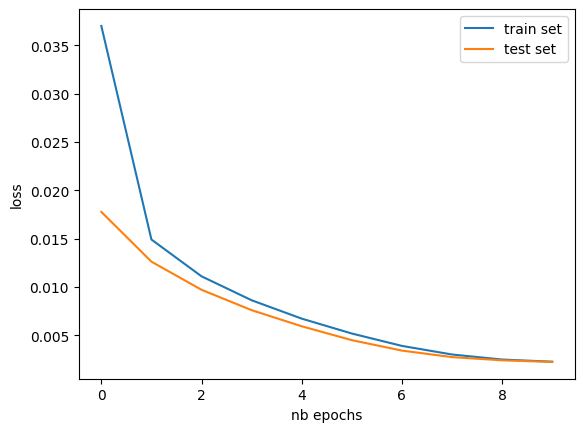

In [58]:
plt.plot(range(num_epochs),u,label='train set')
plt.plot(range(num_epochs),v,label='test set')
plt.xlabel("nb epochs")
plt.ylabel("loss")
plt.legend()

## Seconde classe AE

In [59]:
class AE2(torch.nn.Module):
    def __init__(self):
        super().__init__()
         
        self.encoder = nn.Sequential(nn.Linear(784, 128),
                                     nn.ReLU(),
                                     nn.Linear(128,64),
                                     nn.Tanh()
                                     )

                                     
        self.decoder = nn.Sequential(nn.Linear(64, 128),
                                     nn.Sigmoid(),
                                     nn.Linear(128,784),
                                     nn.ReLU()
                                    )



        self.decoder[0].weight = nn.Parameter(self.encoder[2].weight.t())
        self.decoder[2].weight = nn.Parameter(self.encoder[0].weight.t())

 
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    

In [61]:
from torch.utils.tensorboard import SummaryWriter
from datetime import datetime

venv_dir = "/home/amailys/TP/AMAL/TP2" # Dossier où se trouve le script
log_dir = os.path.join(venv_dir, "logs", f"test_{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}")
writer = SummaryWriter(log_dir=log_dir)




model = AE2().to(device)
optimizer=torch.optim.Adam(model.parameters(),lr=epsilon)
loss_fn=nn.MSELoss()

checkpoint_dir=os.getcwd()
save_name="checkpoints2.pt"
state=State(model, 
            optimizer,
            save_dir=checkpoint_dir,
            save_name=save_name
            )


checkpoint_path = os.path.join(checkpoint_dir, save_name)
if os.path.exists(checkpoint_path):
    start_epoch= state.load(checkpoint_path)
else:
    start_epoch = 0 


u=[]
v=[]
num_epochs = 10  # Nombre d'époques
epsilon=0.001

for epoch in tqdm(range(start_epoch,start_epoch+num_epochs)):
    
    
    cumloss_train=0
    for data in dl_train:
        # Obtenir les entrées
        inputs, _ = data  # _ car nous n'avons pas besoin des labels

        outputs = model(inputs)
        loss = loss_fn(outputs, inputs)

        cumloss_train+=loss.item()

        loss.backward()

        optimizer.step()
        optimizer.zero_grad()



    cumloss_test=0
    with torch.no_grad(): 
        for data in dl_test:
            inputs,_= data  # _ car nous n'avons pas besoin des labels
            outputs = model(inputs)
            loss = loss_fn(outputs, inputs)

            cumloss_test+=loss.item()

    u.append(cumloss_train/(70_000*0.8//50))
    v.append(cumloss_test/(70_000*0.2//50))

    if (epoch + 1) % 10 == 0:
        state.save(epoch + 1)
    if epoch <= 5:
        image_test, _ = ds_test[0]
        image_test_pred = state.model(image_test)
        writer.add_image("Reconstructions", image_test_pred.view(1, 28, 28), epoch)
        writer.add_image("Originals", image_test.view(1, 28, 28), epoch)

writer.close()

#commande terminal 
#tensorboard --logdir=/home/amailys/TP/AMAL/TP2/logs


  0%|          | 0/10 [00:00<?, ?it/s]

100%|██████████| 10/10 [00:47<00:00,  4.78s/it]


array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

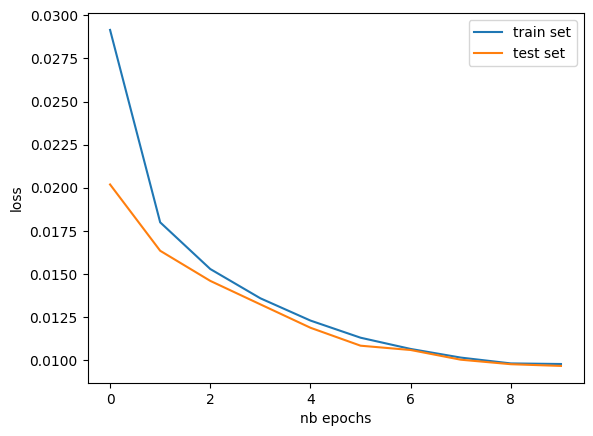

In [26]:
plt.plot(range(num_epochs),u,label='train set')
plt.plot(range(num_epochs),v,label='test set')
plt.xlabel("nb epochs")
plt.ylabel("loss")
plt.legend()